In [ ]:
###
### Basic, Model 1, 1000 samples
###

In [1]:
# Model 1, limit samples to 1000

import csv
import cv2
import numpy as np

# read data in from csv file
lines = []
with open('data/driving_log.csv') as csvfile :
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
            
# Remove the header line
lines = lines[1:]
        
images = []
measurements = []
steering_correction = 0.2  # may need adjustment
data_path = 'data/'

for line in lines:
    #steering measurement (center)
    measurement = float(line[3])
    
    #center image
    current_path = data_path + line[0]
    image = cv2.imread(current_path)
    images.append(image)
    measurements.append(measurement) # no correction for center
    """
    #left image
    current_path = data_path + line[1].strip()
    image = cv2.imread(current_path)
    images.append(image)
    measurements.append(measurement + steering_correction)
    #right image
    current_path = data_path + line[2].strip()
    image = cv2.imread(current_path)
    images.append(image)
    measurements.append(measurement - steering_correction)
    """
    
X_train = np.array(images)
y_train = np.array(measurements)

X_train = X_train[:1000]
y_train = y_train[:1000]

print(X_train.shape)


(1000, 160, 320, 3)


In [2]:
# Model 1, 1000 samples
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Flatten(input_shape=(160,320,3)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True)

model.save('model.h5')
print('Model saved')

Using TensorFlow backend.


Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 2s - loss: 37408512.9499 - val_loss: 10807803.6800
Epoch 2/10
800/800 [==============================] - 0s - loss: 2594785.5537 - val_loss: 37864.6630

In [ ]:
###
### Basic, Model 2, center images only (~8000 samples)
###

In [1]:
# Model 2, limit samples to just center images

import csv
import cv2
import numpy as np

# read data in from csv file
lines = []
with open('data/driving_log.csv') as csvfile :
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
            
# Remove the header line
lines = lines[1:]
        
images = []
measurements = []
steering_correction = 0.2  # may need adjustment
data_path = 'data/'

for line in lines:
    #steering measurement (center)
    measurement = float(line[3])
    
    #center image
    current_path = data_path + line[0]
    image = cv2.imread(current_path)
    images.append(image)
    measurements.append(measurement) # no correction for center
    """
    #left image
    current_path = data_path + line[1].strip()
    image = cv2.imread(current_path)
    images.append(image)
    measurements.append(measurement + steering_correction)
    #right image
    current_path = data_path + line[2].strip()
    image = cv2.imread(current_path)
    images.append(image)
    measurements.append(measurement - steering_correction)
    """
    
X_train = np.array(images)
y_train = np.array(measurements)

print(X_train.shape)


(8036, 160, 320, 3)


In [2]:
# Model 2, to see if things are working correctly
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Flatten(input_shape=(160,320,3)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True)

model.save('model.h5')
print('Model saved')

Using TensorFlow backend.


Train on 6428 samples, validate on 1608 samples
Epoch 1/10
6428/6428 [==============================] - 6s - loss: 5155080.6889 - val_loss: 4028.8831

In [21]:
#####################################
#####################################
#
# Duplicate data by flipping images
#
#   don't run again
#
#####################################
#####################################

import os
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

all_samples = []
with open('additional_data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        all_samples.append(line)

# remove the header line
all_samples = all_samples[1:]

# duplicate data by flipping images and negating steering angle
data_path = 'additional_data/'

def get_flipped_fname(fname) :
    new_fname = fname.rstrip('.jpg')
    new_fname = new_fname.lstrip(data_path)
    new_fname += '_rev.jpg'
    new_fname = data_path + new_fname
    return new_fname


with open('additional_data/driving_log.csv', 'a') as csvfile:
    writer = csv.writer(csvfile)
    for line in all_samples:
        center_image_fname = data_path + line[0]
        center_image = cv2.imread(center_image_fname)
        center_image_flipped = np.fliplr(center_image)
        new_center_fname = get_flipped_fname(center_image_fname)
        cv2.imwrite(new_center_fname, center_image_flipped)

        left_image_fname = data_path + line[1].strip()
        left_image = cv2.imread(left_image_fname)
        left_image_flipped = np.fliplr(left_image)
        new_left_fname = get_flipped_fname(left_image_fname)
        cv2.imwrite(new_left_fname, left_image_flipped)

        right_image_fname = data_path + line[2].strip()
        right_image = cv2.imread(right_image_fname)
        right_image_flipped = np.fliplr(right_image)
        new_right_fname = get_flipped_fname(right_image_fname)
        cv2.imwrite(new_right_fname, right_image_flipped)

        steering = -float(line[3])
        throttle = line[4]
        brake = line[5]
        speed = line[6]

        fields = [new_center_fname, new_left_fname, new_right_fname, steering, throttle, brake, speed]
        writer.writerow(fields)

In [ ]:
##################

In [1]:
###
### Actual model, based on NVIDIA, Model 3, using a generator
###  (start here to retrain, or after changing model architecture)

In [ ]:
#################

In [22]:
# Using a generator

import os
import csv
import numpy as np

all_samples = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        all_samples.append(line)

# remove the header line
all_samples = all_samples[1:]

# randomly remove 80% of data where steering = 0 to eliminate 0 angle bias
samples = []
for line in all_samples:
    center_angle = float(line[3])
    if(center_angle != 0.0 or (center_angle == 0 and np.random.random() < 0.2)):
        samples.append(line)

print(len(samples))

43735


Total data points =  43735


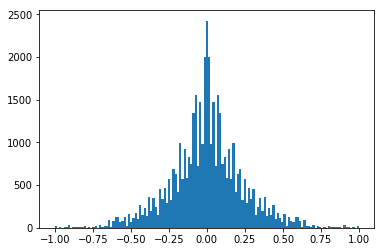

Total zero angles =  2245  Percentage =  0.051331885217788954


In [23]:
# plot steering data
import numpy as np
import matplotlib.pyplot as plt

total_samples = len(samples)
print('Total data points = ', total_samples)

angles = []
for line in samples:
    center_angle = float(line[3])
    angles.append(center_angle)

plt.hist(angles, bins='auto')
plt.show()

total_zero_angles = total_samples - np.count_nonzero(angles)
print('Total zero angles = ', total_zero_angles, ' Percentage = ', total_zero_angles / total_samples)

In [24]:
import cv2
import numpy as np

def preprocess_image(image) :
    # need to crop, normalize, rescale here (grayscale?)

    # change image to RGB since imread reads in BGR
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop top 65 and bottom 25 rows of image for sky and hood
    image = image[65:135, :, :]
    #grayscale here
    #image = np.dot(image[...,:3], [[0.299],[0.587],[0.114]])
    #image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #plt.imshow(image_gray, cmap='gray')
    #resize to 64x64
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
    #normalize
    image = image / 255.0 - 0.5
    
    return image



IMG/center_2017_11_03_16_32_24_395_rev.jpg


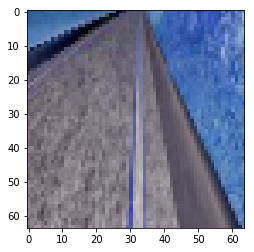

In [25]:
# check what preprocessed images look like

fname = samples[np.random.randint(len(samples))][0]
print(fname)
test_image = cv2.imread('data/' + fname)
test_image = preprocess_image(test_image)
# undo normalization to get a reasonable picture
test_image = (test_image + 0.5) * 255.0
plt.imshow(test_image)
plt.show()



In [26]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import cv2
import numpy as np
import sklearn


train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print('Training samples = ', len(train_samples))
print('Validation samples = ', len(validation_samples))

steering_correction = 0.2

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                # randomly choose between left, right and center images
                lcr_image = np.random.randint(3)
                angle = float(batch_sample[3])
                if lcr_image == 0:
                    name = 'data/IMG/'+ batch_sample[0].split('/')[-1]
                elif lcr_image == 1:
                    name = 'data/IMG/'+ batch_sample[1].split('/')[-1]
                    angle += steering_correction
                else:
                    name = 'data/IMG/'+ batch_sample[2].split('/')[-1]
                    angle -= steering_correction

                lcr_image = cv2.imread(name)
                lcr_image = preprocess_image(lcr_image)
                
                images.append(lcr_image)
                angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

Training samples =  34988
Validation samples =  8747


In [27]:
###
###  NVIDIA model
###

In [28]:
# NVIDIA model with slight modifications for conv size, dropout
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D


# compile and train the model using the generator function
batch_size = 32

train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)


model = Sequential()
# 5 convolutional layers
model.add(Convolution2D(24,(5,5), strides=(2,2), padding='same', input_shape=(64,64,3), data_format='channels_last', activation='relu'))
model.add(Convolution2D(36,(5,5), strides=(2,2), padding='same', activation='relu'))
model.add(Convolution2D(48,(5,5), strides=(2,2), padding='same', activation='relu'))
model.add(Convolution2D(64,(3,3), strides=(2,2), padding='same', activation='relu'))
model.add(Convolution2D(64,(3,3), strides=(2,2), padding='same', activation='relu'))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation=None))

"""
print('Model summary')
model.summary()
for layer in model.layers:
    print(layer.get_output_at(0).get_shape().as_list())
    print('\n')
    print('Input shape =' , layer.input_shape)
    print('Output shape =', layer.output_shape)

"""
model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, steps_per_epoch= len(train_samples)/batch_size,
                    epochs=7,
                    validation_data=validation_generator, 
                    validation_steps=len(validation_samples)/batch_size)

model.save('model.h5')
print('Model saved')


Using TensorFlow backend.


Epoch 1/7
1094/1093 [==============================] - 497s - loss: 0.0486 - val_loss: 0.0349